In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from queue import PriorityQueue
from scipy.spatial import Voronoi
from bresenham import bresenham


In [2]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))
    print(north_min, north_max)

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))
    print(east_min, east_max)
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))
    print(north_size, east_size)
    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(north - d_north - safety_distance - north_min_center),
                int(north + d_north + safety_distance - north_min_center),
                int(east - d_east - safety_distance - east_min_center),
                int(east + d_east + safety_distance - east_min_center),
            ]
            grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1

    return grid



def a_star(grid, heuristic_func, start, goal):
    """
    Given a grid and heuristic function returns
    the lowest cost path from start to goal.
    """

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False

    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            # Get the new vertexes connected to the current vertex
            for a in valid_actions(grid, current_node):
                next_node = (current_node[0] + a.delta[0], current_node[1] + a.delta[1])
                new_cost = current_cost + a.cost + heuristic_func(next_node, goal)

                if next_node not in visited:
                    visited.add(next_node)
                    queue.put((new_cost, next_node))

                    branch[next_node] = (new_cost, current_node, a)

    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])

    return path[::-1], path_cost


# Assume all actions cost the same.
class Action(Enum):
    """
    An action is represented by a 3 element tuple.

    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    NORTHWEST = (-1, -1, np.sqrt(2))
    SOUTHWEST = (1, -1, np.sqrt(2))
    NORTHEAST = (-1, 1, np.sqrt(2))
    SOUTHEAST = (1, 1, np.sqrt(2))
    WEST = (0, -1, 1)
    EAST = (0, 1, 1)
    NORTH = (-1, 0, 1)
    SOUTH = (1, 0, 1)

    @property
    def cost(self):
        return self.value[2]

    @property
    def delta(self):
        return (self.value[0], self.value[1])


def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid_actions = list(Action)
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node

    #print("X: {} Y: {}".format(x,y))
    if x - 1 < 0 or grid[x - 1, y] == 1:
        valid_actions.remove(Action.NORTH)
        #print("Removed NORTH")
    if x + 1 > n or grid[x + 1, y] == 1:
        valid_actions.remove(Action.SOUTH)
        #print("Removed SOUTH")
    if y - 1 < 0 or grid[x, y - 1] == 1:
        valid_actions.remove(Action.WEST)
        #print("Removed WEST")
    if y + 1 > m or grid[x, y + 1] == 1:
        valid_actions.remove(Action.EAST)
        #print("Removed EAST")
    if x - 1 < 0 and y + 1 > m or grid[x - 1, y + 1] == 1:
        valid_actions.remove(Action.NORTHEAST)
        #print("Removed NORTHEAST")
    if x - 1 < 0 and y - 1 < 0 or grid[x - 1,y - 1] == 1:
        valid_actions.remove(Action.NORTHWEST)
        #print("Removed NORTHWEST")
    if x + 1 > n and y + 1 > m or grid[x + 1,y + 1] == 1:
        valid_actions.remove(Action.SOUTHEAST)
        #print("Removed SOUTHEAST")
    if x + 1 > n and y -1 < 0 or grid[x + 1,y - 1] == 1:
        valid_actions.remove(Action.SOUTHWEST)
        #print("Removed SOUTHWEST")
        
    return valid_actions


In [3]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)


In [4]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 3

In [5]:
grid = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)


-316.0 605.0
-445.0 476.0
921 921


In [6]:
def heuristic_func(position, goal_position):
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        # If the 3 points are in a line remove
        # the 2nd point.
        # The 3rd point now becomes and 2nd point
        # and the check is redone with a new third point
        # on the next iteration.
        if collinearity_check(p1, p2, p3):
            # Something subtle here but we can mutate
            # `pruned_path` freely because the length
            # of the list is check on every iteration.
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path


Local Start and Goal:  (316, 444) (739, 357)
Found a path.
Original Path Length: 425
Pruned Path Length: 17


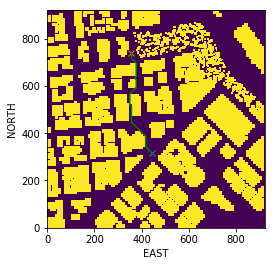

In [7]:
#(316, 444) (739, 357)
grid_start = (316, 444)
grid_goal = (739, 357)

print('Local Start and Goal: ', grid_start, grid_goal)
path, _ = a_star(grid, heuristic_func, grid_start, grid_goal)
print("Original Path Length: {}".format(len(path)))
path = prune_path(path)
print("Pruned Path Length: {}".format(len(path)))

plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.rcParams['figure.figsize'] = 12, 12
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [10]:
from skimage.morphology import medial_axis
from skimage.util import invert

# Assuming you've already created the grid
# The medial_axis() method requires that we invert the grid image
skeleton = medial_axis(invert(grid))
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, origin='lower', alpha=0.7)
plt.show()


ModuleNotFoundError: No module named 'skimage'

In [ ]:
def find_start_goal(skel, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()
    skel_cells = np.transpose(skel.nonzero())
    start_min_dist = np.linalg.norm(np.array(start) - np.array(skel_cells), axis=1).argmin()
    near_start = skel_cells[start_min_dist]
    goal_min_dist = np.linalg.norm(np.array(goal) - np.array(skel_cells), axis=1).argmin()
    near_goal = skel_cells[goal_min_dist]
    
    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, grid_start, grid_goal)

print(grid_start, grid_goal)
print(skel_start, skel_goal)

In [ ]:
path, cost = a_star(invert(skeleton).astype(np.int), heuristic_func, tuple(skel_start), tuple(skel_goal))
print("Path length = {0}, path cost = {1}".format(len(path), cost))

In [9]:
plt.plot(skel_start[1], skel_start[0], 'x')
plt.plot(skel_goal[1], skel_goal[0], 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, origin='lower')
plt.imshow(skeleton, origin='lower', alpha=0.7)
plt.show()


NameError: name 'skel_start' is not defined